# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed-celeba-small.zip
# From https://stackoverflow.com/questions/3451111/unzipping-files-in-python/3451150 
#import zipfile
#zip = zipfile.ZipFile('processed-celeba-small.zip')
#zip.extractall()

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    num_workers = 0
    transform = transforms.Compose([
        transforms.CenterCrop(img_size),
        transforms.ToTensor()
    ])
    
    train_data = data_dir
    
    train_loader = datasets.ImageFolder(train_data, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_loader, batch_size=batch_size, shuffle=True)
    return train_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

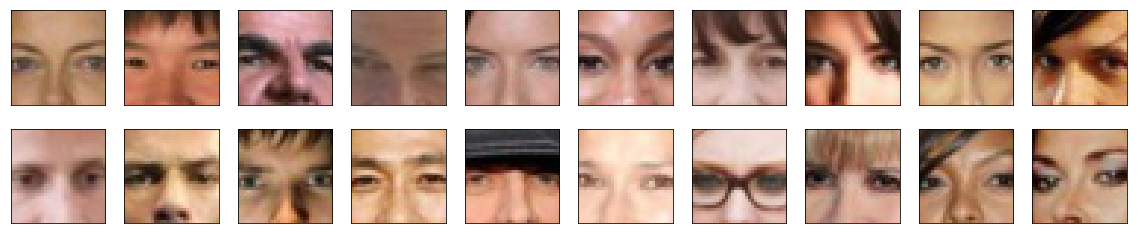

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min_value, max_value = feature_range
    x = x * (max_value - min_value) + min_value
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.7020)
Max:  tensor(0.6549)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layer = []
    conv2d_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    layer.append(conv2d_layer)

    if batch_norm:
        layer.append(nn.BatchNorm2d(out_channels))
     
    return nn.Sequential(*layer)

def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layer = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    layer.append(transpose_conv_layer)
    
    if batch_norm:
        layer.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layer)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        # 1st layer (input=32x32); no batch_norm
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        # 2nd layer (output=16X16)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 3rd layer
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        # hidden layers as well as leaky relu
        output = F.leaky_relu(self.conv1(x), 0.2)
        output = F.leaky_relu(self.conv2(output), 0.2)
        output = F.leaky_relu(self.conv3(output), 0.2)
        
        # flatten 
        output = output.view(-1, self.conv_dim*4*4*4)
        
        # fianl layer
        output = self.fc(output)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose the conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        output = self.fc(x)
        output = output.view(-1, self.conv_dim*4, 4, 4)
        # (batch_size, depth, 4, 4)
        
        # hiddden, transpose cov2d layers plus relu
        output = F.relu(self.t_conv1(output))
        output = F.relu(self.t_conv2(output))
        
        # final layer and hyperbolic tangent
        output = self.t_conv3(output)
        output = F.tanh(output)
        return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

C:\Users\madis\Anaconda3\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
from torch.nn import init
def weights_init_normal(m, init_type='normal', init_gain=0.02):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    def init_func(m):
        classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    # From https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
                if init_type == 'normal':
                    init.normal_(m.weight.data, 0.0, init_gain)
                elif init_type == 'xavier':
                    init.xavier_normal_(m.weight.data, gain=init_gain)
                elif init_type == 'kaiming':
                    init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
                elif init_type == 'orthogonal':
                    init.orthogonal_(m.weight.data, gain=init_gain)
                else:
                    raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
                if hasattr(m, 'bias') and m.bias is not None:
                    init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
                init.normal_(m.weight.data, 1.0, init_gain)
                init.constant_(m.bias.data, 0.0)
    print('initialize network with %s' % init_type)
    m.apply(init_func) 

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [14]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32 
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, k

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [16]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    if(smooth):
        labels = torch.ones(batch_size)*0.9
        # If smooth is true, both smooth and labels are equal to 0.9
    else:
        labels = torch.ones(batch_size)
        # Else, labels are equal to one (1)
    if(train_on_gpu):
        labels = labels.cuda()
        # Move to GPU, assuming it is available
    criterion = nn.BCEWithLogitsLoss()
    # Selected as the result of this function having ~both~ signmoid and binary cross entory loss in just one (1) function
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    # Sets labels to a series of zeros (e.g. 0, 0, 0, .... 0)
    if(train_on_gpu):
        labels = labels.cuda()
        # Move to GPU, assuming it is available
    criterion = nn.BCEWithLogitsLoss()
    # Selected as the result of this function having ~both~ signmoid and binary cross entory loss in just one (1) function
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [17]:
import torch.optim as optim

# my paras
lr = 0.0002
beta1=0.5
beta2=0.999 

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [18]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            if (train_on_gpu):
                real_images = real_images.cuda()
            
            fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
            fixed_z = torch.from_numpy(fixed_z).float()
            
            if (train_on_gpu):
                fixed_z = fixed_z.cuda()
            
            fakes_d = G(fixed_z)
            
            D_real = D(real_images)
            D_fakes = D(fakes_d)
            d_loss = real_loss(D_real, smooth=True) + fake_loss(D_fakes)
            d_loss.backward()
            d_optimizer.step()
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
            fixed_z = torch.from_numpy(fixed_z).float()
            
            if (train_on_gpu):
                fixed_z = fixed_z.cuda()
                
            fakes_g = G(fixed_z)
            fakes = D(fakes_g)
            g_loss = real_loss(fakes, smooth=True)
            # Flips the labels
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [19]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.4018 | g_loss: 1.0534
Epoch [    1/   50] | d_loss: 0.3843 | g_loss: 3.4812
Epoch [    1/   50] | d_loss: 0.6815 | g_loss: 3.0486
Epoch [    1/   50] | d_loss: 0.4091 | g_loss: 3.8395
Epoch [    1/   50] | d_loss: 0.6688 | g_loss: 1.4515
Epoch [    1/   50] | d_loss: 1.0166 | g_loss: 2.9906
Epoch [    1/   50] | d_loss: 0.7250 | g_loss: 3.3430
Epoch [    1/   50] | d_loss: 0.9200 | g_loss: 2.9334
Epoch [    1/   50] | d_loss: 0.6780 | g_loss: 2.4785
Epoch [    1/   50] | d_loss: 0.7890 | g_loss: 2.3133
Epoch [    1/   50] | d_loss: 0.8028 | g_loss: 1.4498
Epoch [    1/   50] | d_loss: 0.7049 | g_loss: 1.8279
Epoch [    1/   50] | d_loss: 0.5824 | g_loss: 1.6994
Epoch [    1/   50] | d_loss: 0.8126 | g_loss: 1.3137
Epoch [    1/   50] | d_loss: 0.7621 | g_loss: 1.2971
Epoch [    1/   50] | d_loss: 0.9958 | g_loss: 1.1498
Epoch [    1/   50] | d_loss: 0.7284 | g_loss: 1.6741
Epoch [    1/   50] | d_loss: 1.0043 | g_loss: 1.6441
Epoch [    1/   50] | d_loss

Epoch [    3/   50] | d_loss: 0.7962 | g_loss: 1.4486
Epoch [    3/   50] | d_loss: 0.4627 | g_loss: 2.3242
Epoch [    3/   50] | d_loss: 0.6969 | g_loss: 1.1933
Epoch [    3/   50] | d_loss: 0.6038 | g_loss: 2.3675
Epoch [    3/   50] | d_loss: 0.5945 | g_loss: 2.3215
Epoch [    3/   50] | d_loss: 0.5239 | g_loss: 3.1971
Epoch [    3/   50] | d_loss: 0.9852 | g_loss: 1.9200
Epoch [    3/   50] | d_loss: 1.0646 | g_loss: 1.6532
Epoch [    3/   50] | d_loss: 0.7589 | g_loss: 1.9706
Epoch [    3/   50] | d_loss: 1.1098 | g_loss: 1.7449
Epoch [    3/   50] | d_loss: 0.6740 | g_loss: 2.2870
Epoch [    3/   50] | d_loss: 0.5328 | g_loss: 3.0844
Epoch [    3/   50] | d_loss: 0.5022 | g_loss: 2.4383
Epoch [    3/   50] | d_loss: 0.6164 | g_loss: 2.0652
Epoch [    3/   50] | d_loss: 0.6504 | g_loss: 1.8849
Epoch [    3/   50] | d_loss: 0.5494 | g_loss: 1.3491
Epoch [    3/   50] | d_loss: 1.5675 | g_loss: 4.7192
Epoch [    3/   50] | d_loss: 0.4338 | g_loss: 2.0991
Epoch [    3/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.4276 | g_loss: 3.0571
Epoch [    6/   50] | d_loss: 0.4866 | g_loss: 3.3143
Epoch [    6/   50] | d_loss: 0.4342 | g_loss: 3.7444
Epoch [    6/   50] | d_loss: 0.7532 | g_loss: 2.5025
Epoch [    6/   50] | d_loss: 0.4516 | g_loss: 2.2207
Epoch [    6/   50] | d_loss: 0.4421 | g_loss: 4.4924
Epoch [    6/   50] | d_loss: 0.6661 | g_loss: 1.4316
Epoch [    6/   50] | d_loss: 0.4796 | g_loss: 1.9874
Epoch [    6/   50] | d_loss: 0.9903 | g_loss: 1.9988
Epoch [    6/   50] | d_loss: 0.6035 | g_loss: 2.4778
Epoch [    6/   50] | d_loss: 0.5379 | g_loss: 3.3157
Epoch [    6/   50] | d_loss: 0.4632 | g_loss: 3.0072
Epoch [    6/   50] | d_loss: 0.7486 | g_loss: 4.3179
Epoch [    6/   50] | d_loss: 0.4465 | g_loss: 2.7847
Epoch [    6/   50] | d_loss: 0.4348 | g_loss: 3.9136
Epoch [    6/   50] | d_loss: 0.8270 | g_loss: 1.6305
Epoch [    6/   50] | d_loss: 0.5501 | g_loss: 2.2018
Epoch [    6/   50] | d_loss: 0.4391 | g_loss: 3.7683
Epoch [    6/   50] | d_loss

Epoch [    8/   50] | d_loss: 0.5856 | g_loss: 2.0730
Epoch [    8/   50] | d_loss: 0.4870 | g_loss: 2.7247
Epoch [    8/   50] | d_loss: 0.4919 | g_loss: 3.8492
Epoch [    9/   50] | d_loss: 0.6989 | g_loss: 2.0506
Epoch [    9/   50] | d_loss: 0.4017 | g_loss: 1.9656
Epoch [    9/   50] | d_loss: 0.5316 | g_loss: 2.0271
Epoch [    9/   50] | d_loss: 0.4273 | g_loss: 5.1747
Epoch [    9/   50] | d_loss: 0.4444 | g_loss: 3.0588
Epoch [    9/   50] | d_loss: 0.4739 | g_loss: 3.9832
Epoch [    9/   50] | d_loss: 1.5778 | g_loss: 1.1923
Epoch [    9/   50] | d_loss: 0.4997 | g_loss: 2.4542
Epoch [    9/   50] | d_loss: 0.6756 | g_loss: 2.2441
Epoch [    9/   50] | d_loss: 0.4545 | g_loss: 3.7187
Epoch [    9/   50] | d_loss: 0.6036 | g_loss: 3.4840
Epoch [    9/   50] | d_loss: 0.4513 | g_loss: 2.3676
Epoch [    9/   50] | d_loss: 0.4874 | g_loss: 3.0324
Epoch [    9/   50] | d_loss: 0.4127 | g_loss: 2.4139
Epoch [    9/   50] | d_loss: 0.5876 | g_loss: 2.6963
Epoch [    9/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.8034 | g_loss: 3.8590
Epoch [   11/   50] | d_loss: 0.5372 | g_loss: 2.2392
Epoch [   11/   50] | d_loss: 0.4332 | g_loss: 2.9251
Epoch [   11/   50] | d_loss: 0.5472 | g_loss: 3.0354
Epoch [   11/   50] | d_loss: 0.6332 | g_loss: 3.6565
Epoch [   11/   50] | d_loss: 0.3931 | g_loss: 3.6416
Epoch [   11/   50] | d_loss: 0.4475 | g_loss: 3.8024
Epoch [   11/   50] | d_loss: 0.4297 | g_loss: 3.0940
Epoch [   11/   50] | d_loss: 0.5974 | g_loss: 2.8006
Epoch [   11/   50] | d_loss: 0.4397 | g_loss: 2.9879
Epoch [   11/   50] | d_loss: 0.4975 | g_loss: 2.9529
Epoch [   11/   50] | d_loss: 0.8426 | g_loss: 2.1355
Epoch [   11/   50] | d_loss: 0.5707 | g_loss: 4.1577
Epoch [   11/   50] | d_loss: 0.4054 | g_loss: 3.1076
Epoch [   11/   50] | d_loss: 0.5164 | g_loss: 3.6986
Epoch [   11/   50] | d_loss: 0.4770 | g_loss: 3.2085
Epoch [   11/   50] | d_loss: 0.4783 | g_loss: 2.9155
Epoch [   11/   50] | d_loss: 0.6617 | g_loss: 2.8289
Epoch [   11/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.4269 | g_loss: 3.3266
Epoch [   14/   50] | d_loss: 0.5075 | g_loss: 3.5303
Epoch [   14/   50] | d_loss: 0.3786 | g_loss: 4.7122
Epoch [   14/   50] | d_loss: 0.4196 | g_loss: 3.4058
Epoch [   14/   50] | d_loss: 0.4242 | g_loss: 1.9032
Epoch [   14/   50] | d_loss: 0.4536 | g_loss: 1.9302
Epoch [   14/   50] | d_loss: 0.4555 | g_loss: 2.5025
Epoch [   14/   50] | d_loss: 0.4832 | g_loss: 3.5768
Epoch [   14/   50] | d_loss: 0.3927 | g_loss: 3.7813
Epoch [   14/   50] | d_loss: 0.6992 | g_loss: 2.6819
Epoch [   14/   50] | d_loss: 0.4533 | g_loss: 2.8365
Epoch [   14/   50] | d_loss: 0.5538 | g_loss: 2.9558
Epoch [   14/   50] | d_loss: 0.4211 | g_loss: 3.6145
Epoch [   14/   50] | d_loss: 0.4627 | g_loss: 1.9223
Epoch [   14/   50] | d_loss: 0.5183 | g_loss: 3.9006
Epoch [   14/   50] | d_loss: 0.4113 | g_loss: 4.2269
Epoch [   14/   50] | d_loss: 0.4357 | g_loss: 2.9595
Epoch [   14/   50] | d_loss: 0.5818 | g_loss: 3.2040
Epoch [   14/   50] | d_loss

Epoch [   16/   50] | d_loss: 0.4590 | g_loss: 2.6995
Epoch [   16/   50] | d_loss: 0.8970 | g_loss: 2.1074
Epoch [   16/   50] | d_loss: 0.6401 | g_loss: 1.7561
Epoch [   16/   50] | d_loss: 0.4268 | g_loss: 2.9372
Epoch [   16/   50] | d_loss: 0.6211 | g_loss: 2.8134
Epoch [   16/   50] | d_loss: 0.4511 | g_loss: 2.8170
Epoch [   17/   50] | d_loss: 0.4505 | g_loss: 2.7312
Epoch [   17/   50] | d_loss: 0.4086 | g_loss: 3.6314
Epoch [   17/   50] | d_loss: 0.4342 | g_loss: 4.5462
Epoch [   17/   50] | d_loss: 0.4120 | g_loss: 2.9337
Epoch [   17/   50] | d_loss: 0.3896 | g_loss: 4.2511
Epoch [   17/   50] | d_loss: 0.3713 | g_loss: 3.6482
Epoch [   17/   50] | d_loss: 0.4826 | g_loss: 4.3455
Epoch [   17/   50] | d_loss: 0.4335 | g_loss: 3.4242
Epoch [   17/   50] | d_loss: 0.4986 | g_loss: 2.0665
Epoch [   17/   50] | d_loss: 0.3784 | g_loss: 3.5479
Epoch [   17/   50] | d_loss: 0.4300 | g_loss: 3.1897
Epoch [   17/   50] | d_loss: 0.4276 | g_loss: 2.3139
Epoch [   17/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.4143 | g_loss: 4.0262
Epoch [   19/   50] | d_loss: 1.4813 | g_loss: 2.1407
Epoch [   19/   50] | d_loss: 0.5785 | g_loss: 2.5174
Epoch [   19/   50] | d_loss: 0.6194 | g_loss: 3.1483
Epoch [   19/   50] | d_loss: 0.6232 | g_loss: 1.3104
Epoch [   19/   50] | d_loss: 0.6086 | g_loss: 3.2324
Epoch [   19/   50] | d_loss: 0.3739 | g_loss: 3.0541
Epoch [   19/   50] | d_loss: 0.4158 | g_loss: 3.0793
Epoch [   19/   50] | d_loss: 0.4686 | g_loss: 2.6013
Epoch [   19/   50] | d_loss: 0.3688 | g_loss: 4.5154
Epoch [   19/   50] | d_loss: 0.3934 | g_loss: 3.5290
Epoch [   19/   50] | d_loss: 0.4985 | g_loss: 3.8428
Epoch [   19/   50] | d_loss: 0.4951 | g_loss: 4.2273
Epoch [   19/   50] | d_loss: 0.4642 | g_loss: 3.5384
Epoch [   19/   50] | d_loss: 0.6484 | g_loss: 3.4563
Epoch [   19/   50] | d_loss: 0.5433 | g_loss: 3.9584
Epoch [   19/   50] | d_loss: 0.4444 | g_loss: 2.2865
Epoch [   19/   50] | d_loss: 0.4023 | g_loss: 2.9994
Epoch [   19/   50] | d_loss

Epoch [   22/   50] | d_loss: 0.4017 | g_loss: 3.0387
Epoch [   22/   50] | d_loss: 0.4331 | g_loss: 3.3854
Epoch [   22/   50] | d_loss: 0.4357 | g_loss: 3.7380
Epoch [   22/   50] | d_loss: 0.3807 | g_loss: 3.4487
Epoch [   22/   50] | d_loss: 0.3783 | g_loss: 3.4811
Epoch [   22/   50] | d_loss: 0.4423 | g_loss: 3.3056
Epoch [   22/   50] | d_loss: 0.4214 | g_loss: 4.0272
Epoch [   22/   50] | d_loss: 0.5380 | g_loss: 2.6094
Epoch [   22/   50] | d_loss: 1.9132 | g_loss: 0.3968
Epoch [   22/   50] | d_loss: 0.4448 | g_loss: 3.1389
Epoch [   22/   50] | d_loss: 0.6157 | g_loss: 4.0436
Epoch [   22/   50] | d_loss: 0.7693 | g_loss: 1.8612
Epoch [   22/   50] | d_loss: 0.4809 | g_loss: 2.2840
Epoch [   22/   50] | d_loss: 0.4540 | g_loss: 3.3675
Epoch [   22/   50] | d_loss: 0.4163 | g_loss: 3.6097
Epoch [   22/   50] | d_loss: 0.4458 | g_loss: 4.2616
Epoch [   22/   50] | d_loss: 0.4024 | g_loss: 3.2787
Epoch [   22/   50] | d_loss: 0.3980 | g_loss: 4.3511
Epoch [   22/   50] | d_loss

Epoch [   24/   50] | d_loss: 0.4971 | g_loss: 3.8889
Epoch [   24/   50] | d_loss: 0.3968 | g_loss: 4.1969
Epoch [   24/   50] | d_loss: 0.4892 | g_loss: 3.3276
Epoch [   24/   50] | d_loss: 0.5047 | g_loss: 3.2788
Epoch [   24/   50] | d_loss: 0.5972 | g_loss: 2.6669
Epoch [   24/   50] | d_loss: 0.4298 | g_loss: 3.3988
Epoch [   24/   50] | d_loss: 0.3840 | g_loss: 3.9735
Epoch [   24/   50] | d_loss: 0.3846 | g_loss: 3.3394
Epoch [   24/   50] | d_loss: 0.4291 | g_loss: 2.6058
Epoch [   25/   50] | d_loss: 1.6843 | g_loss: 8.1244
Epoch [   25/   50] | d_loss: 0.4808 | g_loss: 3.3698
Epoch [   25/   50] | d_loss: 0.4824 | g_loss: 2.8120
Epoch [   25/   50] | d_loss: 0.5744 | g_loss: 3.1859
Epoch [   25/   50] | d_loss: 0.3730 | g_loss: 4.4648
Epoch [   25/   50] | d_loss: 0.4410 | g_loss: 3.9014
Epoch [   25/   50] | d_loss: 0.4616 | g_loss: 4.3528
Epoch [   25/   50] | d_loss: 0.4323 | g_loss: 2.1023
Epoch [   25/   50] | d_loss: 0.4745 | g_loss: 1.5789
Epoch [   25/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.3921 | g_loss: 3.0620
Epoch [   27/   50] | d_loss: 0.8166 | g_loss: 1.9106
Epoch [   27/   50] | d_loss: 0.5040 | g_loss: 3.5310
Epoch [   27/   50] | d_loss: 0.3827 | g_loss: 4.6438
Epoch [   27/   50] | d_loss: 0.3974 | g_loss: 4.0697
Epoch [   27/   50] | d_loss: 0.3646 | g_loss: 3.8141
Epoch [   27/   50] | d_loss: 0.3717 | g_loss: 5.0714
Epoch [   27/   50] | d_loss: 0.4004 | g_loss: 3.3649
Epoch [   27/   50] | d_loss: 0.4072 | g_loss: 3.6320
Epoch [   27/   50] | d_loss: 0.4083 | g_loss: 3.3495
Epoch [   27/   50] | d_loss: 0.4166 | g_loss: 4.9452
Epoch [   27/   50] | d_loss: 0.4900 | g_loss: 1.8287
Epoch [   27/   50] | d_loss: 0.3670 | g_loss: 3.8199
Epoch [   27/   50] | d_loss: 0.4661 | g_loss: 3.4970
Epoch [   27/   50] | d_loss: 0.4764 | g_loss: 3.9888
Epoch [   27/   50] | d_loss: 0.3834 | g_loss: 2.6122
Epoch [   27/   50] | d_loss: 0.4301 | g_loss: 2.8053
Epoch [   27/   50] | d_loss: 0.4301 | g_loss: 1.9190
Epoch [   27/   50] | d_loss

Epoch [   30/   50] | d_loss: 0.4618 | g_loss: 2.2780
Epoch [   30/   50] | d_loss: 0.3623 | g_loss: 3.6202
Epoch [   30/   50] | d_loss: 0.4972 | g_loss: 2.9244
Epoch [   30/   50] | d_loss: 0.3820 | g_loss: 4.8244
Epoch [   30/   50] | d_loss: 0.4517 | g_loss: 4.7847
Epoch [   30/   50] | d_loss: 0.3705 | g_loss: 2.8811
Epoch [   30/   50] | d_loss: 0.4194 | g_loss: 3.9714
Epoch [   30/   50] | d_loss: 0.3751 | g_loss: 4.5431
Epoch [   30/   50] | d_loss: 0.5908 | g_loss: 2.3015
Epoch [   30/   50] | d_loss: 0.5079 | g_loss: 3.4685
Epoch [   30/   50] | d_loss: 0.4985 | g_loss: 2.6682
Epoch [   30/   50] | d_loss: 0.4271 | g_loss: 4.9980
Epoch [   30/   50] | d_loss: 0.3508 | g_loss: 3.9751
Epoch [   30/   50] | d_loss: 0.4106 | g_loss: 3.1917
Epoch [   30/   50] | d_loss: 0.9975 | g_loss: 1.6628
Epoch [   30/   50] | d_loss: 0.3496 | g_loss: 3.8565
Epoch [   30/   50] | d_loss: 0.5089 | g_loss: 4.3625
Epoch [   30/   50] | d_loss: 0.3880 | g_loss: 4.5163
Epoch [   30/   50] | d_loss

Epoch [   32/   50] | d_loss: 0.4452 | g_loss: 3.6447
Epoch [   32/   50] | d_loss: 0.3764 | g_loss: 2.7706
Epoch [   32/   50] | d_loss: 0.3988 | g_loss: 4.7339
Epoch [   32/   50] | d_loss: 0.6200 | g_loss: 2.9354
Epoch [   32/   50] | d_loss: 0.4901 | g_loss: 2.9541
Epoch [   32/   50] | d_loss: 0.3888 | g_loss: 5.2796
Epoch [   32/   50] | d_loss: 0.4088 | g_loss: 3.3845
Epoch [   32/   50] | d_loss: 0.3617 | g_loss: 3.8962
Epoch [   32/   50] | d_loss: 0.4512 | g_loss: 3.3759
Epoch [   32/   50] | d_loss: 0.4352 | g_loss: 4.4510
Epoch [   32/   50] | d_loss: 0.4584 | g_loss: 3.2795
Epoch [   32/   50] | d_loss: 0.5211 | g_loss: 4.0726
Epoch [   33/   50] | d_loss: 0.5173 | g_loss: 2.7082
Epoch [   33/   50] | d_loss: 0.4024 | g_loss: 4.2238
Epoch [   33/   50] | d_loss: 0.4097 | g_loss: 3.3226
Epoch [   33/   50] | d_loss: 0.4331 | g_loss: 2.8911
Epoch [   33/   50] | d_loss: 0.4200 | g_loss: 4.6875
Epoch [   33/   50] | d_loss: 0.4078 | g_loss: 3.2052
Epoch [   33/   50] | d_loss

Epoch [   35/   50] | d_loss: 0.4016 | g_loss: 4.6705
Epoch [   35/   50] | d_loss: 0.3641 | g_loss: 4.1459
Epoch [   35/   50] | d_loss: 0.4023 | g_loss: 4.3146
Epoch [   35/   50] | d_loss: 0.3685 | g_loss: 4.1557
Epoch [   35/   50] | d_loss: 0.7092 | g_loss: 0.7848
Epoch [   35/   50] | d_loss: 0.4033 | g_loss: 4.2210
Epoch [   35/   50] | d_loss: 0.3601 | g_loss: 3.9889
Epoch [   35/   50] | d_loss: 0.3921 | g_loss: 4.7567
Epoch [   35/   50] | d_loss: 0.4723 | g_loss: 3.9408
Epoch [   35/   50] | d_loss: 0.4522 | g_loss: 2.6384
Epoch [   35/   50] | d_loss: 0.3682 | g_loss: 6.0277
Epoch [   35/   50] | d_loss: 0.4323 | g_loss: 3.0541
Epoch [   35/   50] | d_loss: 0.4067 | g_loss: 3.9067
Epoch [   35/   50] | d_loss: 0.3787 | g_loss: 3.7312
Epoch [   35/   50] | d_loss: 0.3702 | g_loss: 4.7927
Epoch [   35/   50] | d_loss: 0.3636 | g_loss: 4.4880
Epoch [   35/   50] | d_loss: 0.4797 | g_loss: 2.3447
Epoch [   35/   50] | d_loss: 0.5405 | g_loss: 3.4864
Epoch [   35/   50] | d_loss

Epoch [   38/   50] | d_loss: 0.4033 | g_loss: 4.3850
Epoch [   38/   50] | d_loss: 0.3849 | g_loss: 5.1469
Epoch [   38/   50] | d_loss: 0.4953 | g_loss: 2.1299
Epoch [   38/   50] | d_loss: 0.3920 | g_loss: 3.5960
Epoch [   38/   50] | d_loss: 0.3893 | g_loss: 4.3509
Epoch [   38/   50] | d_loss: 0.3977 | g_loss: 3.6623
Epoch [   38/   50] | d_loss: 0.4759 | g_loss: 4.0813
Epoch [   38/   50] | d_loss: 0.9769 | g_loss: 2.2037
Epoch [   38/   50] | d_loss: 0.4198 | g_loss: 2.5266
Epoch [   38/   50] | d_loss: 0.4446 | g_loss: 4.8241
Epoch [   38/   50] | d_loss: 0.3835 | g_loss: 3.4012
Epoch [   38/   50] | d_loss: 0.3804 | g_loss: 3.7199
Epoch [   38/   50] | d_loss: 0.3535 | g_loss: 4.2984
Epoch [   38/   50] | d_loss: 0.4225 | g_loss: 2.7429
Epoch [   38/   50] | d_loss: 0.3742 | g_loss: 3.6468
Epoch [   38/   50] | d_loss: 0.3857 | g_loss: 4.4436
Epoch [   38/   50] | d_loss: 0.3802 | g_loss: 3.1480
Epoch [   38/   50] | d_loss: 0.5607 | g_loss: 2.5542
Epoch [   38/   50] | d_loss

Epoch [   40/   50] | d_loss: 0.3708 | g_loss: 4.0840
Epoch [   40/   50] | d_loss: 0.3820 | g_loss: 3.2899
Epoch [   40/   50] | d_loss: 0.4670 | g_loss: 2.7752
Epoch [   40/   50] | d_loss: 0.4588 | g_loss: 4.0697
Epoch [   40/   50] | d_loss: 0.3728 | g_loss: 3.8003
Epoch [   40/   50] | d_loss: 0.3753 | g_loss: 3.9807
Epoch [   40/   50] | d_loss: 0.4502 | g_loss: 3.0996
Epoch [   40/   50] | d_loss: 0.3722 | g_loss: 5.7979
Epoch [   40/   50] | d_loss: 0.3790 | g_loss: 3.9080
Epoch [   40/   50] | d_loss: 0.3798 | g_loss: 3.2037
Epoch [   40/   50] | d_loss: 0.4401 | g_loss: 4.6457
Epoch [   40/   50] | d_loss: 0.4253 | g_loss: 4.3508
Epoch [   40/   50] | d_loss: 0.3807 | g_loss: 4.7970
Epoch [   40/   50] | d_loss: 0.3626 | g_loss: 4.7412
Epoch [   40/   50] | d_loss: 0.4311 | g_loss: 5.0795
Epoch [   41/   50] | d_loss: 0.4007 | g_loss: 3.4500
Epoch [   41/   50] | d_loss: 0.5412 | g_loss: 4.6744
Epoch [   41/   50] | d_loss: 0.3804 | g_loss: 3.6110
Epoch [   41/   50] | d_loss

Epoch [   43/   50] | d_loss: 0.5860 | g_loss: 4.7976
Epoch [   43/   50] | d_loss: 0.3938 | g_loss: 4.1312
Epoch [   43/   50] | d_loss: 0.3821 | g_loss: 2.5362
Epoch [   43/   50] | d_loss: 0.5478 | g_loss: 3.7617
Epoch [   43/   50] | d_loss: 0.5121 | g_loss: 4.0335
Epoch [   43/   50] | d_loss: 0.4354 | g_loss: 4.1479
Epoch [   43/   50] | d_loss: 0.4032 | g_loss: 3.5086
Epoch [   43/   50] | d_loss: 0.4122 | g_loss: 4.6323
Epoch [   43/   50] | d_loss: 0.4396 | g_loss: 4.0502
Epoch [   43/   50] | d_loss: 0.3884 | g_loss: 3.2537
Epoch [   43/   50] | d_loss: 0.3883 | g_loss: 4.3272
Epoch [   43/   50] | d_loss: 0.3803 | g_loss: 2.8460
Epoch [   43/   50] | d_loss: 0.3633 | g_loss: 3.8614
Epoch [   43/   50] | d_loss: 0.4816 | g_loss: 3.5452
Epoch [   43/   50] | d_loss: 0.3731 | g_loss: 3.3460
Epoch [   43/   50] | d_loss: 0.3814 | g_loss: 3.4879
Epoch [   43/   50] | d_loss: 0.4288 | g_loss: 4.8620
Epoch [   43/   50] | d_loss: 0.3716 | g_loss: 4.6970
Epoch [   43/   50] | d_loss

Epoch [   46/   50] | d_loss: 0.4079 | g_loss: 3.3379
Epoch [   46/   50] | d_loss: 0.4405 | g_loss: 4.0785
Epoch [   46/   50] | d_loss: 0.3602 | g_loss: 2.9944
Epoch [   46/   50] | d_loss: 0.3632 | g_loss: 3.6363
Epoch [   46/   50] | d_loss: 0.3656 | g_loss: 4.2569
Epoch [   46/   50] | d_loss: 0.3866 | g_loss: 4.4619
Epoch [   46/   50] | d_loss: 0.4420 | g_loss: 3.9122
Epoch [   46/   50] | d_loss: 0.3828 | g_loss: 4.0991
Epoch [   46/   50] | d_loss: 0.3507 | g_loss: 3.3276
Epoch [   46/   50] | d_loss: 0.5027 | g_loss: 3.1845
Epoch [   46/   50] | d_loss: 0.5058 | g_loss: 3.5348
Epoch [   46/   50] | d_loss: 0.4493 | g_loss: 4.1239
Epoch [   46/   50] | d_loss: 0.4113 | g_loss: 4.7921
Epoch [   46/   50] | d_loss: 0.5267 | g_loss: 4.4044
Epoch [   46/   50] | d_loss: 0.3571 | g_loss: 5.3449
Epoch [   46/   50] | d_loss: 0.4466 | g_loss: 3.2019
Epoch [   46/   50] | d_loss: 0.3594 | g_loss: 4.7052
Epoch [   46/   50] | d_loss: 0.3707 | g_loss: 3.7890
Epoch [   46/   50] | d_loss

Epoch [   48/   50] | d_loss: 0.3711 | g_loss: 4.6511
Epoch [   48/   50] | d_loss: 0.3632 | g_loss: 4.3380
Epoch [   48/   50] | d_loss: 0.3869 | g_loss: 4.8008
Epoch [   48/   50] | d_loss: 0.3936 | g_loss: 3.3542
Epoch [   48/   50] | d_loss: 0.3806 | g_loss: 5.2112
Epoch [   48/   50] | d_loss: 0.3852 | g_loss: 5.0697
Epoch [   48/   50] | d_loss: 0.4579 | g_loss: 4.5194
Epoch [   48/   50] | d_loss: 0.3849 | g_loss: 4.1638
Epoch [   48/   50] | d_loss: 1.4759 | g_loss: 5.5977
Epoch [   48/   50] | d_loss: 0.5269 | g_loss: 2.1623
Epoch [   48/   50] | d_loss: 0.3652 | g_loss: 4.2296
Epoch [   48/   50] | d_loss: 0.4782 | g_loss: 4.2354
Epoch [   48/   50] | d_loss: 0.4410 | g_loss: 3.3440
Epoch [   48/   50] | d_loss: 0.3650 | g_loss: 5.5271
Epoch [   48/   50] | d_loss: 0.3645 | g_loss: 5.0495
Epoch [   48/   50] | d_loss: 0.3673 | g_loss: 4.9503
Epoch [   48/   50] | d_loss: 0.3721 | g_loss: 4.7340
Epoch [   48/   50] | d_loss: 0.4342 | g_loss: 4.2760
Epoch [   49/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

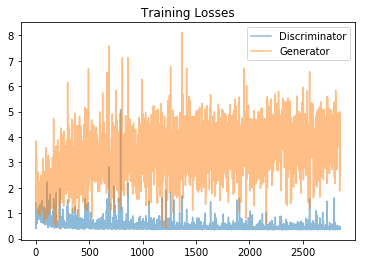

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [24]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    zipped = list(zip(axes.flatten(), samples[epoch]))
    for ax, img in zipped:
            img = img.detach().cpu().numpy()
            img = np.transpose(img, (1, 2, 0))
            img = ((img + 1)*255 / (2)).astype(np.uint8)
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            im = ax.imshow(img.reshape((32,32,3)))

In [25]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

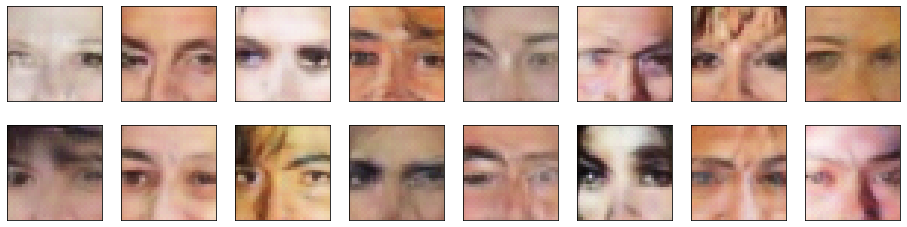

In [26]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:**
I noticed that my sample is biased, which is the result of the training dataset being biased. The training dataset is biased in at least the following ways: 

- Race
- Gender indentity 
- Digital divide status
- Economic status, such as class
- Apperance
- Income 
- Age
- Disabilty status 
- Work / military experience 
- National origin

My sample appears to be mostly pale-skinned people. My sample suggests a theme of not being able to afford acceptable healthcare

The model could be improved by: 

- Increasing the diversity of the training data, such as through race and through disabilty status
- Decreasing the variance of the training data, such as through if the subject if wearing sunglasses
- Increasing the model size
- Improving the optimazation stratgery

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.